<a href="https://colab.research.google.com/github/jsalbr/m3nlp/blob/main/Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answering

**Dieses Notebook sollte mit GPU ausgeführt werden.  
Dafür bitte zunächst im Menü "Laufzeit"->"Laufzeittyp ändern"->"Hardwarebeschleuniger: GPU" einstellen.**

In dieser Version sind bereits alle Zellen ausgeführt.
Wer selbst von vorne anfangen will, am besten übers Menü  
**"Bearbeiten"->"Alle Ausgaben löschen"**.

<hr/>

Credits: Das Notebook verwendet Ideen von
  * Natural Language Processing with Transformers von Lewis Tunstall, Leandro von Werra, Thomas Wolf, O'Reilly 2021, https://www.oreilly.com/library/view/natural-language-processing/9781098103231/
  * Heise Academy NLP-Kurs von Christian Winkler, https://github.com/heiseacademy/nlp-course/tree/main/09_Transfer_Learning
  * Haystack Tutorial von deepset.io, https://github.com/deepset-ai/haystack#mortar_board-tutorials

## System vorbereiten

### Installation von Transformers und Haystack

Achtung: In diesem Notebook werden sowohl die [Transformers-Bibliothek von HuggingFace](https://huggingface.co/transformers/) als auch [Haystack von deepset.ai](https://haystack.deepset.ai/) eingesetzt. 

Leider haben in der aktuellen Version beide Bibliotheken inkompatible Dependencies.
Die Installation hier funktioniert für diese Beispiele, aber es gibt eine Warnung am Ende. In der Praxis kann
es daher zu Problemen kommen. Für produktive Zwecke sollte deshalb mit getrennten
virtuellen Environments arbeiten.

**Geduld:** Die Installation dauert einen Moment.

In [ ]:
!pip install -q farm-haystack==0.10.0 grpcio==1.41.0
# !pip install transformers==4.12.3 datasets
!pip install -q git+https://github.com/huggingface/transformers datasets
!pip install readability-lxml

In [2]:
%load_ext autoreload
%autoreload 2

### Noch ein paar Standard-Einstellungen setzen ...

In [3]:
import pandas as pd
pd.options.display.max_colwidth = 200 # default 50; -1 = all
pd.options.display.float_format = '{:.2f}'.format

from textwrap import wrap, fill

In [4]:
# suppress warnings
import warnings;
warnings.filterwarnings('ignore');

### Und eine kleine Anzeige-Funktion ...

welche mit Antworten sowohl von Transformer als auch von Haystack umgehen kann.

In [5]:
from IPython.display import display, HTML

def display_qa(answers, question='', context='', padding=50):
    if type(answers) != list:
        answers = [answers]
    html = "<table>"
    if len(question) > 0: 
        html += f"<tr><td>Question:</td><td><span style='font-weight:bold'>{question}</span></td></tr>"
        html += f"<tr><td>&nbsp;<td><td> </td></tr>"
    for a in answers:
        if len(a['answer']) > 0:
            html += f"<tr><td>Answer:</td><td><span style='font-weight:bold'>{a['answer']}</span></td></tr>"
        else:
            html += f"<tr><td>Answer:</td><td>answer impossible</td></tr>"
        html += f"<tr><td>Score:</td><td>{a['score']}</td></tr>"
        start = a.get('start', a.get('offset_start'))
        end = a.get('end', a.get('offset_end'))
        html += f"<tr><td>Span:</td><td>{start}:{end}</td></tr>"
        ctx = a.get('context', context)
        if len(a['answer']) > 0 and len(ctx) > 0:
            left = max(0, start-padding)
            right = min(end+padding, len(ctx))
            html += "<tr><td>Snippet:</td><td>"
            html += f"{ctx[left:start]}<span style='color:blue;font-weight:bold'>"
            html += ctx[start:end]
            html += f"</span>{ctx[end:right]}</td>"
        html += f"<tr><td>&nbsp;<td><td> </td></tr>"
    html += '</table><br/>'
    display(HTML(html))


## Arbeit mit einem QA-Modell

Zunächst nutzen wir die [HuggingFace Transformers Library](https://huggingface.co/transformers/), um mit einem vortrainierten QA-Modell zu arbeiten.

### Modell laden

Eine Übersicht über die QA-Modelle auf dem HuggingFace Hub gibt's hier:  
https://huggingface.co/models?pipeline_tag=question-answering&sort=downloads

Wir nutzen dieses, weil es bei den Beispielen sehr gute Ergebnisse geliefert hat:  
https://huggingface.co/Sahajtomar/German-question-answer-Electra


In [ ]:
from transformers import pipeline

model_name = "Sahajtomar/German-question-answer-Electra"
# device = 0 is GPU
qa = pipeline("question-answering", model=model_name, tokenizer=model_name, device=0)

### Fragen zu Artikel beantworten

Zunächst das Grundprinzip: Das Modell beantwortet Fragen basierend auf dem Kontext, z.B. ein Wikipedia-Eintrag, ein News-Artikel oder ein User-Post.

Hier geht es um diesen Beispielartikel:  
https://www.heise.de/news/Giga-Factory-Berlin-fast-fertig-Erstes-Tesla-Model-Y-noch-dieses-Jahr-6213528.html

In [62]:
context = """Giga Factory Berlin fast fertig – Erstes Tesla Model Y noch dieses Jahr

Elon Musk hat in knapp zwei Jahren eine riesige Fabrik vor die Tore Berlins gesetzt. 
Samstag ließ er erstmals Bürger ein. Nicht alle Nachbarn sind begeistert.

Der US-Elektroautobauer Tesla will spätestens im Dezember in Deutschland die Produktion 
für Europa starten. Dies kündigte Firmengründer Elon Musk am Wochenende bei einem Bürgerfest 
in seinem ersten europäischen Werk bei Berlin an. Kritik von Anwohnern und Umweltschützern 
an der in nur zwei Jahren konzipierten und errichteten Industrieanlage widersprach er. 
Ziel sei "eine wunderschöne Fabrik in Harmonie mit ihrer Umgebung".

Künftig sollen etwa 12.000 Mitarbeiter in Grünheide bis zu 500.000 Elektroautos im Jahr bauen. 
Dabei will Tesla möglichst viele Teile vor Ort produzieren, um von Zulieferern unabhängig zu sein. 
Tesla betont vor allem die Bedeutung der eigenen Druckgussanlage und der hochmodernen Lackiererei. 
Zudem entsteht neben dem Autowerk eine eigene Batteriefabrik.
""".replace('\n', ' ').strip()

Jetzt können wir Fragen stellen:

In [63]:
question="Wer ist Elon Musk?"
answer = qa(question=question, context=context)
answer['answer']

'Firmengründer'

In [64]:
question="Wer ist der Firmengründer?"
answer = qa(question=question, context=context)
answer['answer']

'Elon Musk'

In [65]:
question="Wer gündete Tesla?"
answer = qa(question=question, context=context)
answer['answer']

'Elon Musk'

In [66]:
question="Wer ist begeistert?"
answer = qa(question=question, context=context)
display_qa(answer, question, context)

In [67]:
question="Wer ist nicht begeistert?"
answer = qa(question=question, context=context)
display_qa(answer, question, context)

In [68]:
question="Wie viele?"
answer = qa(question=question, context=context, top_k=5)
display_qa(answer, question, context)

In [69]:
question="Wie viele Mitarbeiter?"
answer = qa(question=question, context=context, top_k=5)
display_qa(answer, question, context)

### Fragen zu <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Game_of_Thrones_2011_logo.svg/420px-Game_of_Thrones_2011_logo.svg.png" width="150"/> beantworten

Für einen längeren Text einen sich Wikipedia-Artikel, wie hier dieser zu "Game of Thrones":  
https://de.wikipedia.org/wiki/Game_of_Thrones



In [25]:
from readability import Document
import requests
from bs4 import BeautifulSoup
doc = Document(requests.get("https://de.wikipedia.org/wiki/Game_of_Thrones", stream=True).text)
soup = BeautifulSoup(doc.summary())            
context = soup.text
len(context)

99932

Das sind ca. 100kB!

In [26]:
question="Wer sind die Geschwister von Arya?"
answer = qa(question=question, context=context)
display_qa(answer, question, context)

In [27]:
question="Wer Tyrion Lennister?"
answer = qa(question=question, context=context)
display_qa(answer, question, context)

In [30]:
question="Wer Tyrion?"
answer = qa(question=question, context=context, top_k=5, max_seq_len=256, doc_stride=0)
display_qa(answer, question, context)

## Deep Dive

In [51]:
question = "Wie viele Menschen leben in Berlin?"
context = "In Deutschland leben ca. 80 Millionen Menschen, allein in Berlin ca. 4 Mio."

answer = qa(question=question, context=context)
display_qa(answer, question, context, padding=1000)

In [52]:
model_name = "Sahajtomar/German-question-answer-Electra"

In [53]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer(question, context, return_tensors="pt");
inputs

{'input_ids': tensor([[ 102,  755, 1358, 1021, 2294,  153, 1270, 1992,  103,  259, 1110, 2294,
         3416,  566, 3243, 1779, 1021,  818, 3385,  153, 1270, 3416,  566,  470,
         3754,  566,  103]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

In [54]:
input_df = pd.DataFrame(
    [tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
     inputs['input_ids'][0].numpy(),
     inputs['token_type_ids'][0].numpy(),
     inputs['attention_mask'][0].numpy()]).T

input_df.columns=['token', 'id', 'type', 'attn']
input_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
token,[CLS],Wie,viele,Menschen,leben,in,Berlin,?,[SEP],In,Deutschland,leben,ca,.,80,Millionen,Menschen,",",allein,in,Berlin,ca,.,4,Mio,.,[SEP]
id,102,755,1358,1021,2294,153,1270,1992,103,259,1110,2294,3416,566,3243,1779,1021,818,3385,153,1270,3416,566,470,3754,566,103
type,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
attn,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [55]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_name)
outputs = model(**inputs)

In [56]:
def maxval_in_col(column):    
    highlight = 'background-color: palegreen;'
    return [highlight if v == column.max() else '' for v in column]

output_df = pd.concat([input_df, 
                       pd.Series(outputs['start_logits'][0].detach(), name='start'),
                       pd.Series(outputs['end_logits'][0].detach(), name='end')], axis=1)

# answer span must be in context (type==1)
output_df.query('type==1')[['token', 'start', 'end']].style.apply(maxval_in_col, subset=['start', 'end'], axis=0)

,token,start,end
9,In,-1.952163,-4.381449
10,Deutschland,-2.193250,-3.163343
11,leben,-3.289760,-3.758742
12,ca,-2.033132,-5.251160
13,.,-4.505715,-4.682586
14,80,-1.377596,-3.567362
15,Millionen,-3.356760,-1.489960
16,Menschen,-2.762764,-1.144014
17,",",-2.974908,-2.032700
18,allein,-0.383163,-1.318787


In [57]:
import torch

start_idx = torch.argmax(outputs.start_logits)
end_idx = torch.argmax(outputs.end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer:   {answer}")

Question: Wie viele Menschen leben in Berlin?
Answer:   4 Mio


## Retriever-Reader mit Haystack

Nun wird ein größeres Szenario simuliert. Stellen Sie sich vor, Sie haben sehr viele Dokumente und suchen darin Antworten. Da suchen Sie die Nadel im Heuhaufen - ein Fall für [Haystack](https://haystack.deepset.ai/).

### Anwendungsbeispiel: Aspect-based Sentiment Analysis

An dieser Stelle soll ein praktisches Anwendungsbeispiel gezeigt werden.
Es geht darum, Kunden-Meinungen zu bestimmten Eigenschaften eines Produkts herauszufinden. Dafür werden Amazon-Reviews zu dem Produkt mit einem QA-Modell "befragt". 

Da wir hier nicht nur einen (Kon-)Text auszuwerten haben, sondern viele Rewiews, wird ein Retriever-Reader-Modell benutzt. Dabei werden durch den Retriever die relevanten Kommentare vorselektiert, um dann durch den Reader ausgewertet zu werden.

Der Datensatz, den wir verwenden, ist ein Auszug aus dem "Subjective QA" Datensatz, den man direkt vom HuggingFace Hub beziehen kann:  
https://huggingface.co/datasets/subjqa

In [ ]:
from datasets import load_dataset

# other options include: books, grocery, movies, restaurants, tripadvisor
data = load_dataset("subjqa", "electronics")
data.set_format("pandas")

# flatten the nested dataset columns for easy access
df = [ds[:] for split, ds in data.flatten().items() if split == 'train'][0]

# select some columns
df = df[["title", "question", "answers.text", "answers.answer_start", "context"]]
df = df.drop_duplicates(subset="context").rename(columns={"answers.text": "answer", "answers.answer_start": "start"})

print(list(df.columns))
print(f"\n{len(df)} rows")

Schauen wir uns ein paar Datensätze an:

In [34]:
df.sample(3, random_state=25)

,title,question,answer,start,context
867,B00691WMJG,What is the quality of room?,[],[],Received drive on Monday. Went to install drive in computer but Windows install couldn't see any drive. Drive was making clicking and beeping noises. Checked on Seagate's support forum and found t...
761,B0058UUR6E,How was the stand?,[The stand is quite good],[139],"This monitor is just plain awesome. The presets are very nice, colors seem to be almost spot on for the gaming option. No ghosting effect. The stand is quite good, no worse then most led monitors...."
940,B0074BW614,What is the audio that is playing?,[The sound quality are great compare to my Ipad],[281],I bought this Kindle fire for my 6 years old daughter. She likes it but she wishes it was white or have a choice of color to choose from. The power buttons and volume button are camouflage and h...


### Befüllen des Document Stores für den Retriever



Haystack unterstützt folgende Document Stores:
  * Elasticsearch (Sparse BM25/TF-IDF + Dense Vectors, https://elastic.co)
  * FAISS (von Facebook AI für Dense Vectors, https://faiss.ai/)
  * SQL (SQLite, PostgreSQL, MySQL)
  * InMemoryDocumentStore

Der Einfachheit halber wird hier der InMemoryDocumentStore genutzt. Für die Praxis wird aber ElasticSearch empfohlen, weil dieser Such-Index neben einer Volltextsuche eine Vielzahl von Filtermöglichkeiten für Metadaten bietet.


Ein Document-Store erwartet folgendes Input-Format:
```python
docs = [
    {
        'text': DOCUMENT_TEXT_HERE,
        'meta': {'name': DOCUMENT_NAME, 'category': DOCUMENT_CATEGORY}
    }, ...
]
```


Für den `InMemoryDocumentStore` wird an dieser Stelle schon einmal auf den zu analysierenden Artikel gefiltert. Wir nehmen diesen hier:

**Panasonic ErgoFit In-Ear Earbud Headphones RP-HJE120-D (Orange) Dynamic Crystal Clear Sound, Ergonomic Comfort-Fit**  

https://www.amazon.com/dp/B003ELYQGG  
https://amazon-asin.com/asincheck/?product_id=B003ELYQGG


In [35]:
# create docs (in the example for one item only)
item_id = "B003ELYQGG"

docs = []
for _, row in df.query(f"title == '{item_id}'").iterrows():
    doc = {"text": row["context"],
           "meta": {"item_id": row["title"]}}
    docs.append(doc)

docs[:3]

[{'meta': {'item_id': 'B003ELYQGG'},
  'text': "I needed new headphones so I got these and the JBuds J3 Micro Atomic In-Ear Earbuds (purchased them for $19.99 now they are $9.99) and planned to test between them and return one. My quick response is that I'll keep the Panasonic. Bass, treble, and mids seem pretty decent. Fit in the ear well and for the $6 I spent, great price. The JBuds have slightly better sound but aren't as good for working out but not good enough to pay an extra $14. So if you want to use your earbuds while running/working out, get the Panasonic. If you're using them to just relax/walk around, the JBuds are slightly better and work it at $9.99."},
 {'meta': {'item_id': 'B003ELYQGG'},
  'text': "I bought these to replace my i-Luv earbud headphones that only lasted a couple of months. Compared the iLuv product, this product fails to meet the mark. First off, no one company were selling all the different colours and I was forced to buy 2 pink ones from Amazon. While th

In [37]:
from haystack.document_store import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

document_store.write_documents(docs, index="document")
print(f"{document_store.get_document_count()} docs loaded.")

35 docs loaded.


### Dokumenten-Suche mit dem Retriever

In [38]:
from haystack.retriever.sparse import TfidfRetriever
retriever = TfidfRetriever(document_store=document_store)

question = "How is the bass?"
retrieved_docs = retriever.retrieve(query=question, top_k=3)
# ElasticSearch would support real filters
# retrieved_docs = retriever.retrieve(query=question, top_k=3, filters={"item_id":[item_id]]})

for doc in retrieved_docs:
    print(fill(doc.text), end="\n\n")

11/09/2021 12:38:12 - INFO - haystack.retriever.sparse -   Found 35 candidate paragraphs from 35 docs in DB


Holy hell. How is this even possible? These headphones were like 6
bucks (the white ones are cheaper) and... they have great sound. If
you turn them up super loud, there's a little rattling or
&#34;fuzz,&#34; but whatever they're 6 dollar ear buds lol. They have
seriously impressive bass and the fit is fantastic. I've tried several
pairs of ear buds in my life, and I've always thought I had stupid
ears because they always fall out. These ARE NOT CYLINDERS. The whole
thing is shaped... weird. And it's awesome. SERIOUSLY, THIS BASS DUDE.
Get these. These are the ones you want. Jeeze this bass is f******
incredible.

Although the sound is nice and neutral, the bass is practically non-
existent. The fit, with the right rubber socks, is fine. It stays in
your ears while moving. I suppose you gets what you pays for.

Im a little surprised at how people are just gushing about how great
these are. Yeah they're good for the price but people are comparing
them to high end earbuds and thats just 

### Antworten bekommen mit dem Reader

Haystack unterstützt zwei Reader, den `FARMReader` und den `TransformersReader`. Beide nutzen Transformer-Modelle, unterscheiden sich aber in kleinen Details, die [hier](https://haystack.deepset.ai/docs/latest/readermd#deeper-dive-farm-vs-transformers) erläutert werden.

Wir nutzen den `FARMReader`. [FARM](https://pypi.org/project/farm/) ist eine Library für das Transfer Learning mit Transformer-Modellen, die selbst wiederum die Transformers Library nutzt.

Eine nette QA-Demo von FARM findet sich hier: https://demos.deepset.ai



In [39]:
from haystack.reader.farm import FARMReader

reader = FARMReader(model_name_or_path=model_name, progress_bar=False,
                    return_no_answer=False, use_gpu=True)

11/09/2021 12:38:48 - INFO - farm.utils -   Using device: CUDA 
11/09/2021 12:38:48 - INFO - farm.utils -   Number of GPUs: 1
11/09/2021 12:38:48 - INFO - farm.utils -   Distributed Training: False
11/09/2021 12:38:48 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of the model checkpoint at Sahajtomar/German-question-answer-Electra were not used when initializing ElectraModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
11/09/2021 12:39:04 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or

In [40]:
question = "How is the bass?"
answers = reader.predict_on_texts(question=question, texts=[retrieved_docs[1].text], top_k=3)
answers

{'answers': [{'answer': 'practically non-existent',
   'context': 'Although the sound is nice and neutral, the bass is practically non-existent. The fit, with the right rubber socks, is fine. It stays in your ears whi',
   'document_id': 'a9fbf99857ff038f521c61457dbbc944',
   'offset_end': 76,
   'offset_end_in_doc': 76,
   'offset_start': 52,
   'offset_start_in_doc': 52,
   'score': 0.5194442868232727}],
 'no_ans_gap': 22.61299228668213,
 'query': 'How is the bass?'}

Haben Sie bemerkt, dass wir immer noch das gleiche Modell verwendet haben mit dem wir auch schon die deutschen Texte analysiert haben?

Das ist mit einem multilingualen Modell möglich! Mit einem rein englischen Modell werden aber auf englischen Texten bessere Ergebnisse erreicht.

### Retriever und Reader in der Haystack-Pipeline

In [41]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, retriever)

In [42]:
question = "How is the bass?"
# question = "Do they sound good?"
# question = "How do they fit?"
answers = pipe.run(query=question, params={"Retriever": {"top_k": 10}, 
                                         "Reader": {"top_k": 5}})

display_qa(answers['answers'], question, padding=500)

### Und natürlich eine WordCloud zum Abschluss 😀

In diesem Beispiel wird aus allen Dokumenten (wir haben nur 35) jeweils die Meinung zum Bass erfragt. Die eindeutigen Antworten werden gezählt und mit einer WordCloud visualisiert. Bei sehr vielen Reviews kann man sich so sehr schnell ein Meinungsbild verschaffen.

In [43]:
from collections import Counter

question = "How is the bass?"
retrieved_docs = retriever.retrieve(query=question, top_k=100)

counter = Counter()
for doc in retrieved_docs:
    answer = reader.predict_on_texts(question=question, texts=[doc.text], top_k=1)['answers'][0]['answer']
    if len(answer) < 30:
        counter.update([answer])

counter

Counter({'Odd shaped earpieces': 1,
         'Sound quality is fantastic': 1,
         'cost is very reasonable': 1,
         'deeper and cleaner': 1,
         'deeper and more precise bass': 1,
         'f****** incredible': 1,
         'fine': 1,
         'fit is just perfect': 1,
         'good': 2,
         'good for the price': 1,
         'great': 2,
         'highs': 1,
         'much bass': 1,
         'noise isolating quality': 1,
         'not obnoxiously long': 1,
         'oval shaped': 1,
         'poor, muffled and tinny': 1,
         'practically non-existent': 1,
         'pretty decent': 1,
         'pretty simple': 1,
         'really thumps': 1,
         'some bass': 1,
         'sound quality is great': 1,
         'the sound is not good': 1,
         'thin': 1,
         'very cheap price': 1,
         'very smooth and powerful': 1,
         'weak': 1,
         'well balanced, beautiful': 1})

(-0.5, 799.5, 399.5, -0.5)

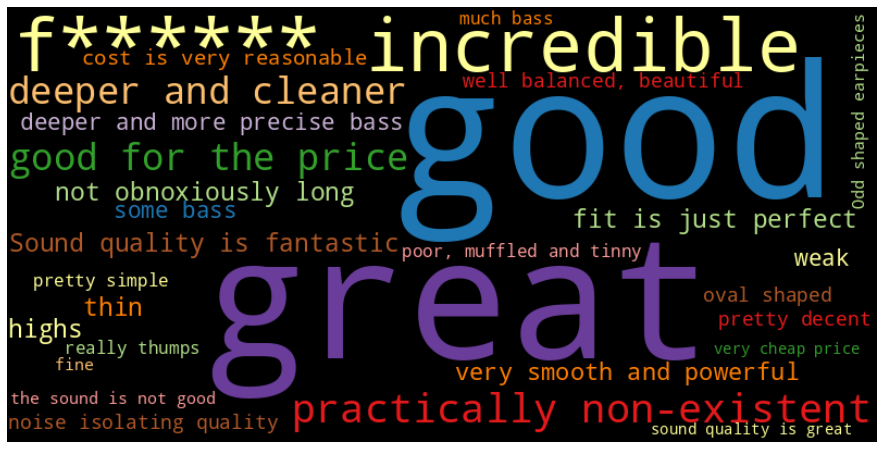

In [44]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

wc = WordCloud(width=800, height=400, background_color= "black", colormap="Paired")
wc.generate_from_frequencies(counter)
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")